In [2]:
nb_inputs = 100
nb_hidden = 4
nb_outputs = 2
time_step = 1e-3
nb_steps = 200
batch_size = 256

In [3]:
import os

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns

import torch
import torch.nn as nn

In [4]:
dtype = torch.float
device = torch.device('mps')

In [5]:
# Generate synthetic data
freq = 5
prob = freq * time_step
mask = torch.rand((batch_size, nb_steps, nb_inputs), device=device, dtype=dtype)
x_data = torch.zeros((batch_size, nb_steps, nb_inputs), device=device, dtype=dtype, requires_grad=False)
x_data[mask < prob] = 1.0

loc("mps_not_equal"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0032d1ee-80fd-11ee-8227-6aecfccc70fe/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":253:0)): error: 'anec.not_equal_zero' op Invalid configuration for the following reasons: Tensor dimensions N1D1C1H1W5120000 are not within supported range, N[1-65536]D[1-16384]C[1-65536]H[1-16384]W[1-16384].
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0032d1ee-80fd-11ee-8227-6aecfccc70fe/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.not_equal_zero' op Invalid configuration for the following reasons: Tensor dimensions N1D1C1H1W5120000 are not within supported range, N[1-65536]D[1-16384]C[1-65536]H[1-16384]W[1-16384].


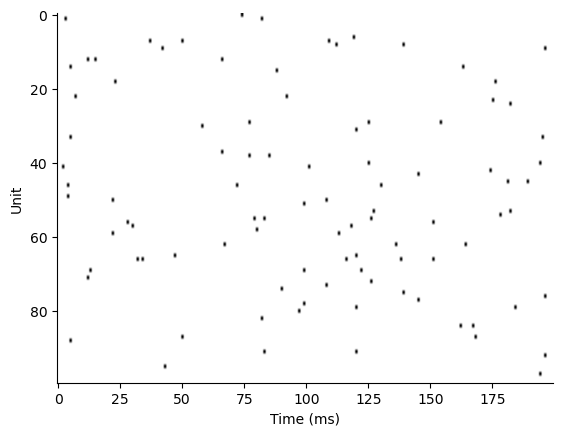

In [6]:
data_id = 0
plt.imshow(x_data[data_id].cpu().t(), cmap=plt.cm.gray_r, aspect="auto")
plt.xlabel("Time (ms)")
plt.ylabel("Unit")
sns.despine()

In [7]:
y_data = torch.tensor(1*(np.random.rand(batch_size)<0.5), device=device)

In [8]:
tau_mem = 10e-3
tau_syn = 5e-3

alpha = float(np.exp(-time_step/tau_syn))
beta = float(np.exp(-time_step/tau_mem))

In [9]:
weight_scale = 7*(1.0-beta)

w1 = torch.empty((nb_inputs, nb_hidden), device=device, dtype=dtype, requires_grad=True)
torch.nn.init.normal_(w1, mean=0.0, std=weight_scale/np.sqrt(nb_inputs))

w2 = torch.empty((nb_hidden, nb_outputs), device=device, dtype=dtype, requires_grad=True)
torch.nn.init.normal_(w2, mean=0.0, std=weight_scale/np.sqrt(nb_hidden))

print("init done!")

init done!


In [10]:
h1 = torch.einsum("abc,cd->abd", (x_data, w1))

In [11]:
def spike_fn(x):
    out = torch.zeros_like(x)
    out[x>0] = 1.0
    return out

In [12]:
syn = torch.zeros((batch_size, nb_hidden), device=device, dtype=dtype)
mem = torch.zeros((batch_size, nb_hidden), device=device, dtype=dtype)

# record membrane potentials
mem_rec = []
spk_rec = []

for t in range(nb_steps):
    mthr = mem - 1.0
    out = spike_fn(mthr)
    rst = out.detach()
    
    new_syn = alpha*syn + h1[:, t]
    new_mem = (beta*mem + syn)*(1.0-rst)
    
    mem_rec.append(mem)
    spk_rec.append(out)
    
    mem = new_mem
    syn = new_syn
    
mem_rec = torch.stack(mem_rec, dim=1)
spk_rec = torch.stack(spk_rec, dim=1)

In [15]:
# Plot helper function
def plot_voltage_traces(mem, spk=None, dim=(3,5), spike_height=5):
    gs = GridSpec(*dim)
    if spk is not None:
        dat = 1.0*mem
        dat[spk>0.0] = spike_height
    else:
        dat = mem.detach().cpu().numpy()
    for i in range(np.prod(dim)):
        if i==0: a0=ax=plt.subplot(gs[i])
        else: ax=plt.subplot(gs[i], sharey=a0)
        if isinstance(dat[i], torch.Tensor):
            ax.plot(dat[i].detach().cpu().numpy())
        else:
            ax.plot(dat[i])
        ax.axis("off")

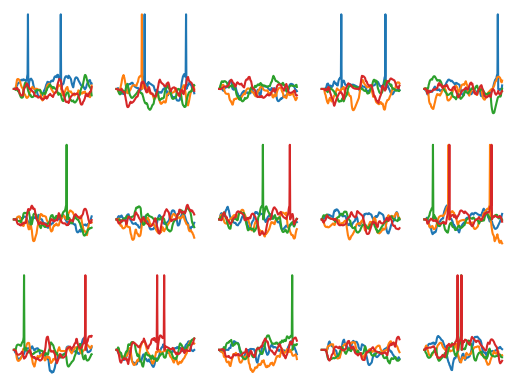

In [16]:
fig=plt.figure(dpi=100)
plot_voltage_traces(mem_rec, spk_rec)

### Adding a ReadOut Layer

In [17]:
# Define the running and the redout layer
def run_snn(inputs):
    h1 = torch.einsum("abc,cd->abd", (inputs, w1))
    syn = torch.zeros((batch_size, nb_hidden), device = device, dtype=dtype)
    mem = torch.zeros((batch_size, nb_hidden), device = device, dtype=dtype)
    
    mem_rec = []
    spk_rec = []
    
    # Compute hidden layer activity
    for t in range(nb_steps):
        mthr = mem - 1.0
        out = spike_fn(mthr)
        rst = out.detach()
        
        new_syn = alpha*syn + h1[:, t]
        new_mem = (beta*mem + syn)*(1.0-rst)
        
        mem_rec.append(mem)
        spk_rec.append(out)
        
        mem = new_mem
        syn = new_syn
        
    mem_rec = torch.stack(mem_rec, dim=1)
    spk_rec = torch.stack(spk_rec, dim=1)
    
    # Readout layer
    h2 = torch.einsum("abc,cd->abd", (spk_rec, w2))
    flt = torch.zeros((batch_size, nb_outputs), device=device, dtype=dtype)
    out = torch.zeros((batch_size, nb_outputs), device=device, dtype=dtype)
    out_rec = [out]
    for t in range(nb_steps):
        new_flt = alpha*flt + h2[:, t]
        new_out = beta * out + flt
        
        flt = new_flt
        out = new_out
        
        out_rec.append(out)
        
    out_rec = torch.stack(out_rec, dim=1)
    other_recs = [mem_rec, spk_rec]
    return out_rec, other_recs

In [18]:
out_rec, other_recs = run_snn(x_data)

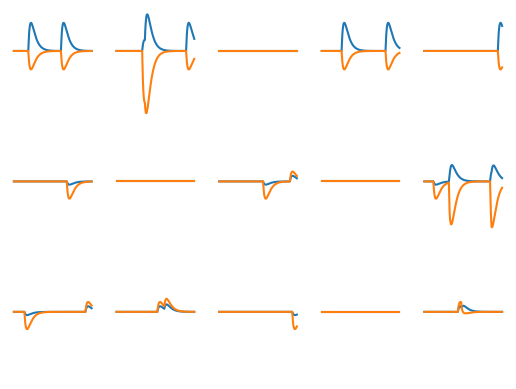

In [19]:
fig=plt.figure(dpi=100)
plot_voltage_traces(out_rec)

In [20]:
def print_classification_accuracy():
    output, _ = run_snn(x_data)
    m, _ = torch.max(output, 1)
    _, am = torch.max(m, 1)
    acc = np.mean((y_data==am).detach().cpu().numpy())
    print("Accuracy %.3f"%acc)
    
print_classification_accuracy()

Accuracy 0.500


### Supervised Learning with True Gradient

In [21]:
# Supervised learning with true gradient
params = [w1, w2] # params we want to optimize
optimizer = torch.optim.Adam(params, lr=2e-3, betas=(0.9, 0.999))

log_softmax_fn = nn.LogSoftmax(dim=1) # Log softmax function across output units
loss_fn = nn.NLLLoss()# The negative log likelihood loss fnct

loss_hist = []
for e in range(1000):
    output, _ = run_snn(x_data)
    m, _ = torch.max(output, 1)
    log_p_y = log_softmax_fn(m)
    loss_val = loss_fn(log_p_y, y_data)
    
    optimizer.zero_grad()
    loss_val.backward()
    optimizer.step()
    
    loss_hist.append(loss_val.item())
    
loss_hist_true_grad = loss_hist

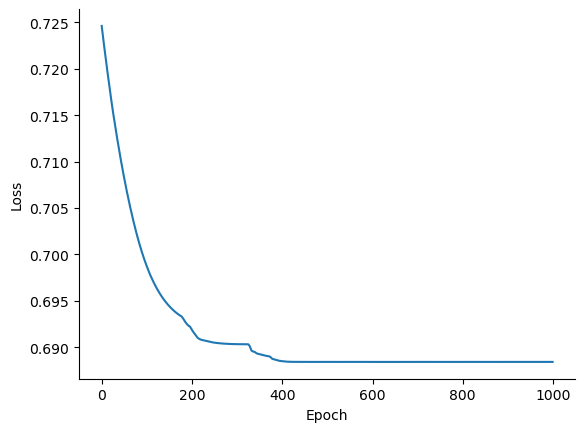

In [22]:
plt.plot(loss_hist)
plt.xlabel("Epoch")
plt.ylabel("Loss")
sns.despine()

In [23]:
print_classification_accuracy()

Accuracy 0.527


In [24]:
output, other_recordings = run_snn(x_data)
mem_rec, spk_rec = other_recordings

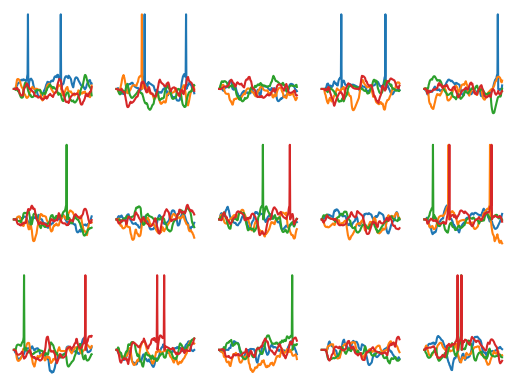

In [25]:
fig=plt.figure(dpi=100)
plot_voltage_traces(mem_rec, spk_rec)

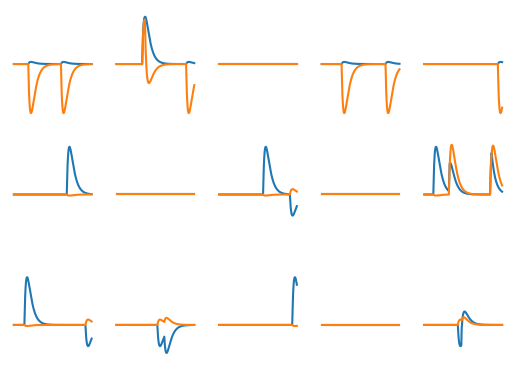

In [26]:
fig=plt.figure(dpi=100)
plot_voltage_traces(output)

### Supervised Learning with Surrogate Gradients

In [27]:
# Define Surrogate Gradient
class SurrGradSpike(torch.autograd.Function):
    scale = 100.0
    
    @staticmethod
    def forward(ctx, input):
        ctx.save_for_backward(input)
        out = torch.zeros_like(input)
        out[input > 0] = 1.0
        return out
    
    @staticmethod
    def backward(ctx, grad_output):
        """
        Use a normalized negative part of a fast sigmoid
        """
        input, = ctx.saved_tensors
        grad_input = grad_output.clone()
        grad = grad_input/(SurrGradSpike.scale*torch.abs(input)+1.0)**2
        return grad
    
spike_fn = SurrGradSpike.apply

In [28]:
# Reinitialize the weights
torch.nn.init.normal_(w1, mean=0.0, std=weight_scale/np.sqrt(nb_inputs))
torch.nn.init.normal_(w2, mean=0.0, std=weight_scale/np.sqrt(nb_hidden))
print("init done")

init done


In [30]:
params = [w1,w2]
optimizer = torch.optim.Adam(params, lr=2e-3, betas=(0.9,0.999))

log_softmax_fn = nn.LogSoftmax(dim=1)
loss_fn = nn.NLLLoss()

loss_hist = []
for e in range(1000):
    output,_ = run_snn(x_data)
    m,_=torch.max(output,1)
    log_p_y = log_softmax_fn(m)
    loss_val = loss_fn(log_p_y, y_data)

    optimizer.zero_grad()
    loss_val.backward()
    optimizer.step()
    loss_hist.append(loss_val.item())

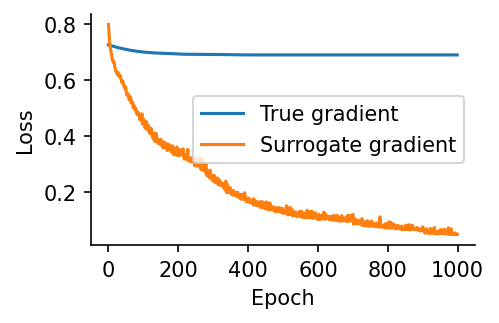

In [31]:
plt.figure(figsize=(3.3, 2),dpi=150)
plt.plot(loss_hist_true_grad, label="True gradient")
plt.plot(loss_hist, label="Surrogate gradient")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
sns.despine()

In [32]:
output, other_recordings = run_snn(x_data)
mem_rec, spk_rec = other_recordings

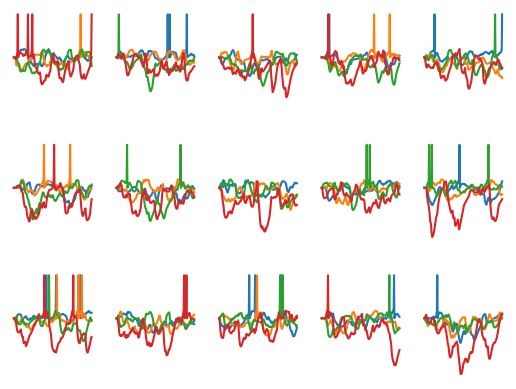

In [33]:
fig=plt.figure(dpi=100)
plot_voltage_traces(mem_rec, spk_rec)

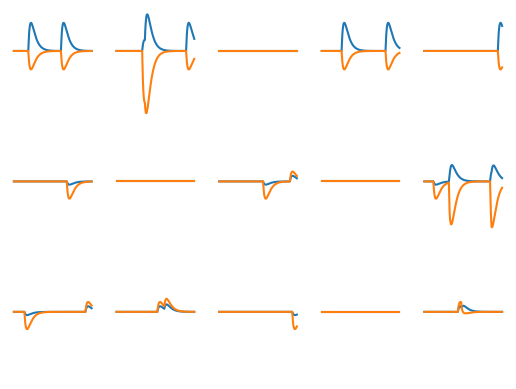

In [34]:
fig=plt.figure(dpi=100)
plot_voltage_traces(out_rec)

In [35]:
output, _ = run_snn(x_data)
m, _ = torch.max(output, 1)

_, am = torch.max(m, 1)
acc = np.mean((y_data==am).detach().cpu().numpy())
print("Accuracy %f"%acc)

Accuracy 0.980469
